<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler, MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Keras
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, TimeDistributed, Dropout, Conv1D, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Common imports
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#Parameters
window_hours = 168 #24*7
forecast_hours = 24
traing_hours = 24*365*2
test_hours = 24*365

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function for plot
def plot_learning_curves(loss, val_loss, x_min_max=None, y_min_max=None):
    if x_min_max is None and y_min_max is None:
        x_min_max = [1,100]
        y_min_max = [0,70]
        
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([x_min_max[0], x_min_max[1], y_min_max[0], y_min_max[1]])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [21]:
#Read csv file
df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)
df=df.dropna()

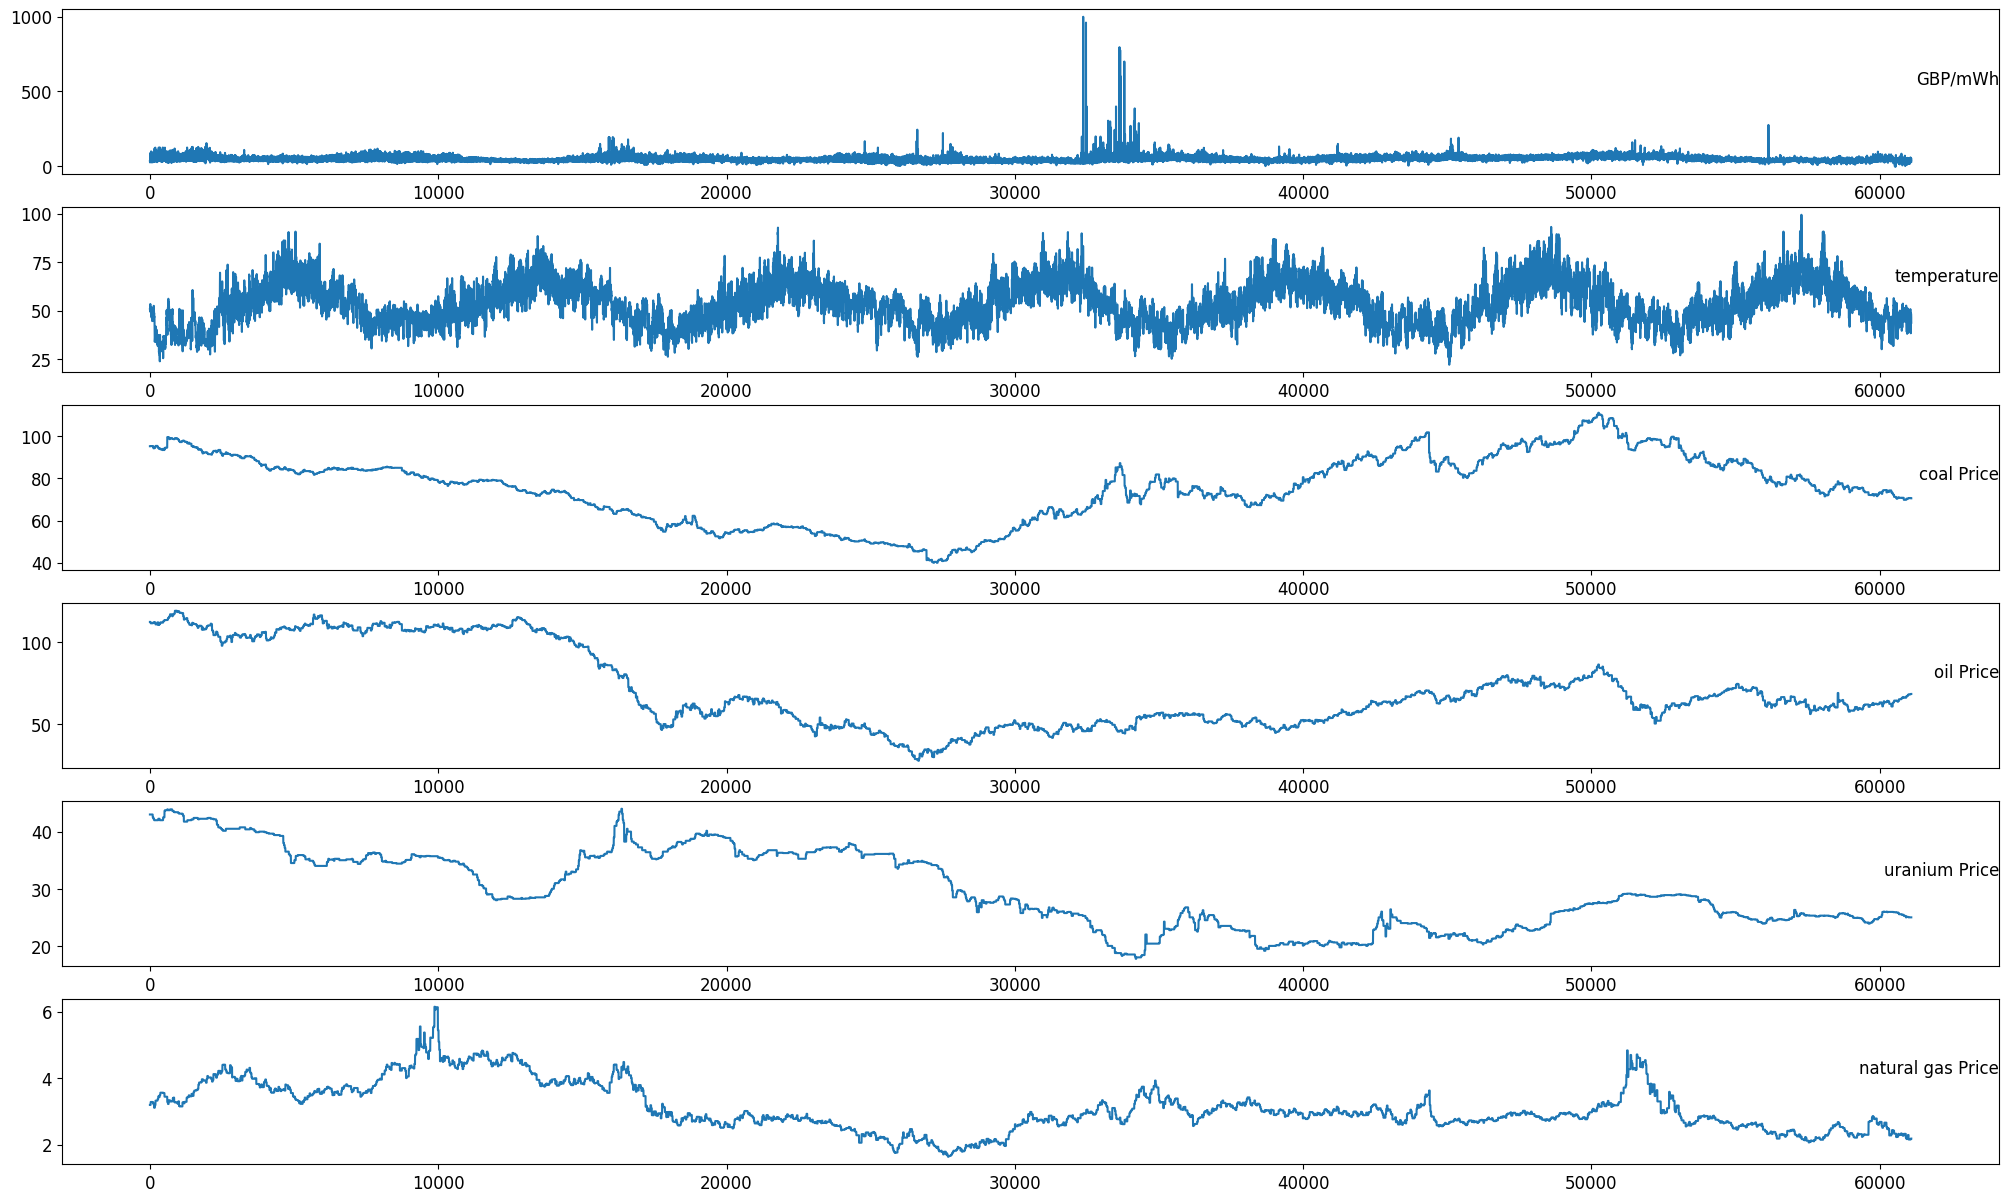

In [22]:
#Plot graph
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [23]:
# Normalize Datafram
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

168+24 인 192 시간으로 데이터를 편집한 것은 168시간으로 학습 시킨 뒤 24 시간을 예측하게 만들기 위함이라 예상됨

In [24]:
# 192hours time window (n_step+24)
series_reshaped =  np.array([data[i:i + (window_hours+forecast_hours)].copy() for i in range(len(data) - (window_hours+forecast_hours))])
print(series_reshaped.shape)

(60905, 192, 6)


In [25]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Train, valid, test data 만들기
X_train = series_reshaped[:traing_hours, :window_hours]
X_valid = series_reshaped[traing_hours:series_reshaped.shape[0]-test_hours, :window_hours]
X_test = series_reshaped[series_reshaped.shape[0]-test_hours:, :window_hours]
Y = np.empty((series_reshaped.shape[0], window_hours, forecast_hours))

for step_ahead in range(1, forecast_hours + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + window_hours, 0]
Y_train = Y[:traing_hours]
Y_valid = Y[traing_hours:series_reshaped.shape[0]-test_hours]
Y_test = Y[series_reshaped.shape[0]-test_hours:]
print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)

(17520, 168, 6) (34625, 168, 6) (8760, 168, 6) (17520, 168, 24) (34625, 168, 24) (8760, 168, 24)


#Note#
X_train.shape = (8760, 168,6) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 결과치를 (6) 6개의 요소에 대해 나타낸 것
Y_train.shape = (8760, 168,24) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 전력가격 결과를 (24) 24시간에 대해 나타낸 것

Deep Multivariate Recurrant Neural Network

In [26]:
#Training 

model6 = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    SimpleRNN(50, return_sequences=True),
    TimeDistributed(keras.layers.Dense(forecast_hours))
])

n_epochs = 500
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model6.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])

Epoch 1/500
548/548 [==============================] - 22s 38ms/step - loss: 41.8053 - val_loss: 59.9320
Epoch 2/500
548/548 [==============================] - 20s 37ms/step - loss: 21.1528 - val_loss: 41.8872
Epoch 3/500
548/548 [==============================] - 20s 37ms/step - loss: 19.4097 - val_loss: 40.5055
Epoch 4/500
548/548 [==============================] - 20s 37ms/step - loss: 18.4766 - val_loss: 39.1143
Epoch 5/500
548/548 [==============================] - 20s 37ms/step - loss: 18.1569 - val_loss: 35.5084
Epoch 6/500
548/548 [==============================] - 20s 37ms/step - loss: 17.0990 - val_loss: 35.4582
Epoch 7/500
548/548 [==============================] - 21s 38ms/step - loss: 15.7744 - val_loss: 31.8962
Epoch 8/500
548/548 [==============================] - 20s 37ms/step - loss: 15.1004 - val_loss: 34.1778
Epoch 9/500
548/548 [==============================] - 21s 38ms/step - loss: 15.3779 - val_loss: 28.4536
Epoch 10/500
548/548 [==============================] -

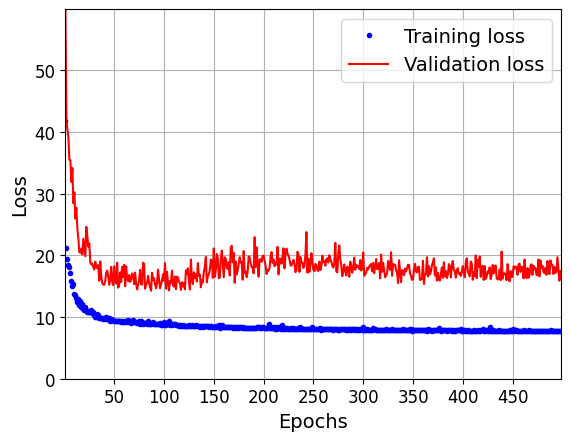

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 3s 10ms/step


<Axes: >

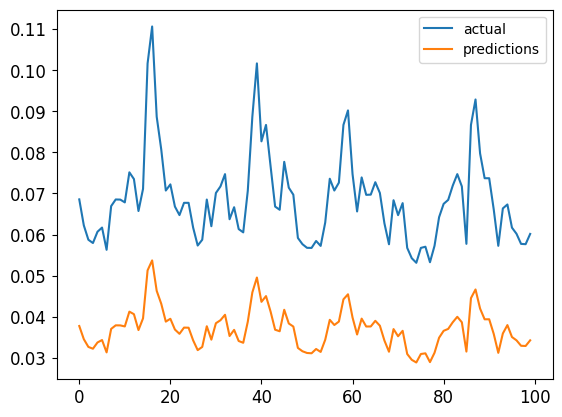

In [28]:
#Predict

Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual1 = actual
actual.to_csv('model_result/SimpleRNNresults.csv') 
actual['actual'][:100].plot(legend=True)
actual['predictions'][:100].plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)

Simple Long-Short Term Memory Model

In [29]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model8 = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model8.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])


Epoch 1/500
548/548 [==============================] - 27s 47ms/step - loss: 31.3698 - val_loss: 39.4396
Epoch 2/500
548/548 [==============================] - 25s 46ms/step - loss: 17.2177 - val_loss: 29.9974
Epoch 3/500
548/548 [==============================] - 25s 46ms/step - loss: 16.0708 - val_loss: 26.4077
Epoch 4/500
548/548 [==============================] - 25s 46ms/step - loss: 14.6799 - val_loss: 24.9565
Epoch 5/500
548/548 [==============================] - 25s 46ms/step - loss: 13.8985 - val_loss: 23.5626
Epoch 6/500
548/548 [==============================] - 25s 46ms/step - loss: 13.4328 - val_loss: 21.4264
Epoch 7/500
548/548 [==============================] - 25s 46ms/step - loss: 13.0410 - val_loss: 19.3159
Epoch 8/500
548/548 [==============================] - 25s 46ms/step - loss: 12.7578 - val_loss: 19.2088
Epoch 9/500
548/548 [==============================] - 25s 46ms/step - loss: 12.4711 - val_loss: 18.9831
Epoch 10/500
548/548 [==============================] -

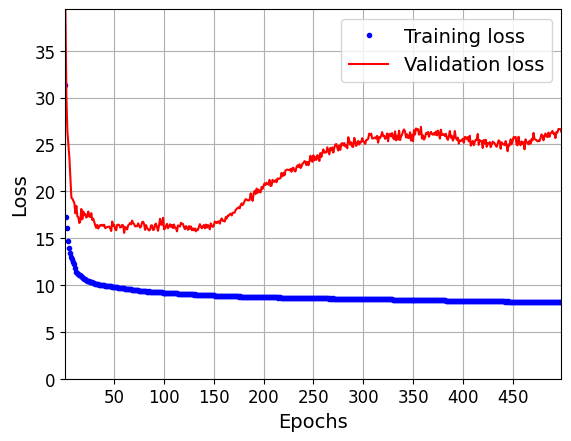

In [30]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 3s 9ms/step


<Axes: >

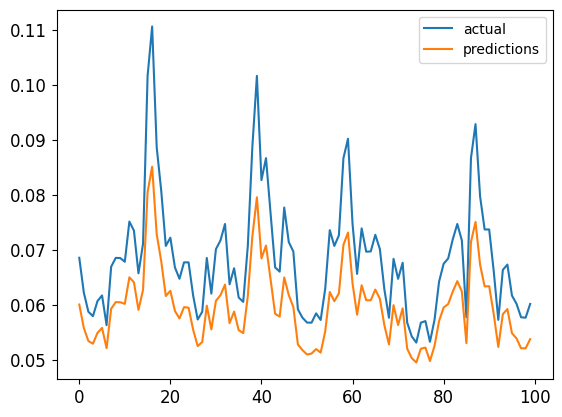

In [31]:
#Predict

Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual2 = actual
actual2.to_csv('model_result/LSTMresults.csv') 
actual2['actual'][:100].plot(legend=True)
actual2['predictions'][:100].plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)

Deep LSTM model

In [32]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model9 = Sequential([
    LSTM(80, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    Dropout(0,2),
    LSTM(40, return_sequences=True),
    Dropout(0,2),
    LSTM(30, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
model9.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history = model9.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks = [mc])
#history = model9.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks = [es,mc])

Epoch 1/500
548/548 [==============================] - 99s 176ms/step - loss: 18.0761 - val_loss: 18.3392
Epoch 2/500
548/548 [==============================] - 96s 175ms/step - loss: 13.4754 - val_loss: 16.6729
Epoch 3/500
548/548 [==============================] - 97s 176ms/step - loss: 12.2087 - val_loss: 17.7597
Epoch 4/500
548/548 [==============================] - 96s 176ms/step - loss: 11.4896 - val_loss: 17.8631
Epoch 5/500
548/548 [==============================] - 97s 176ms/step - loss: 10.8051 - val_loss: 16.4733
Epoch 6/500
548/548 [==============================] - 96s 175ms/step - loss: 10.4708 - val_loss: 16.6036
Epoch 7/500
548/548 [==============================] - 95s 174ms/step - loss: 10.2389 - val_loss: 15.2836
Epoch 8/500
548/548 [==============================] - 95s 173ms/step - loss: 10.0807 - val_loss: 15.3415
Epoch 9/500
548/548 [==============================] - 95s 173ms/step - loss: 9.9449 - val_loss: 16.0992
Epoch 10/500
548/548 [=========================

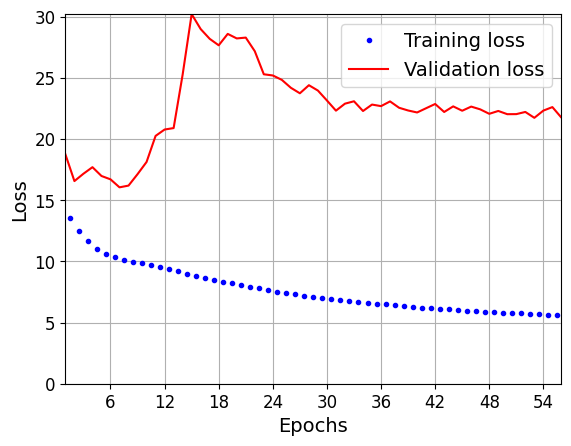

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 9s 32ms/step


<Axes: >

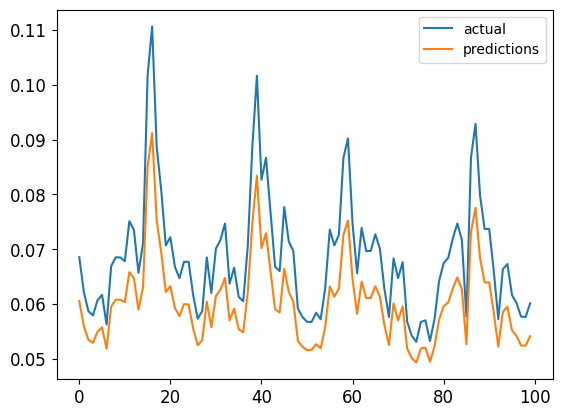

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual3 = actual
actual3.to_csv('model_result/DeepLSTMresults.csv') 
actual3['actual'][:100].plot(legend=True)
actual3['predictions'][:100].plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)

Conv1D?

In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model10 = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, X_train.shape[2]]),
    GRU(60, return_sequences=True),
    GRU(40, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
model10.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [mc])
#history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es,mc])

Epoch 1/500
548/548 [==============================] - 30s 50ms/step - loss: 20.1465 - val_loss: 20.2326
Epoch 2/500
548/548 [==============================] - 27s 49ms/step - loss: 13.9747 - val_loss: 16.8128
Epoch 3/500
548/548 [==============================] - 27s 49ms/step - loss: 12.6040 - val_loss: 16.8075
Epoch 4/500
548/548 [==============================] - 27s 49ms/step - loss: 11.6067 - val_loss: 15.8368
Epoch 5/500
548/548 [==============================] - 27s 49ms/step - loss: 11.1065 - val_loss: 14.8159
Epoch 6/500
548/548 [==============================] - 27s 49ms/step - loss: 10.6634 - val_loss: 14.5553
Epoch 7/500
548/548 [==============================] - 27s 49ms/step - loss: 10.2541 - val_loss: 14.4075
Epoch 8/500
548/548 [==============================] - 27s 49ms/step - loss: 10.0435 - val_loss: 13.9985
Epoch 9/500
548/548 [==============================] - 27s 49ms/step - loss: 9.8779 - val_loss: 14.4603
Epoch 10/500
548/548 [==============================] - 

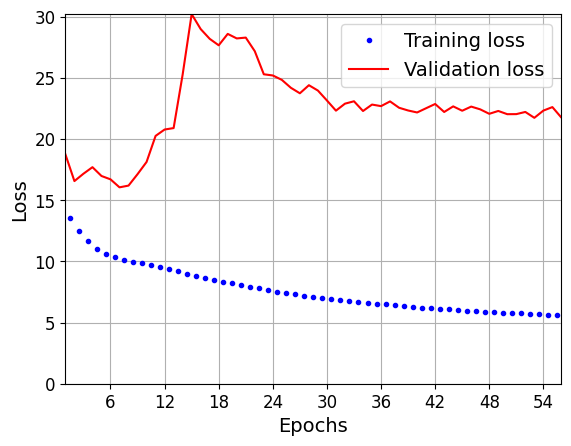

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 9s 32ms/step


<Axes: >

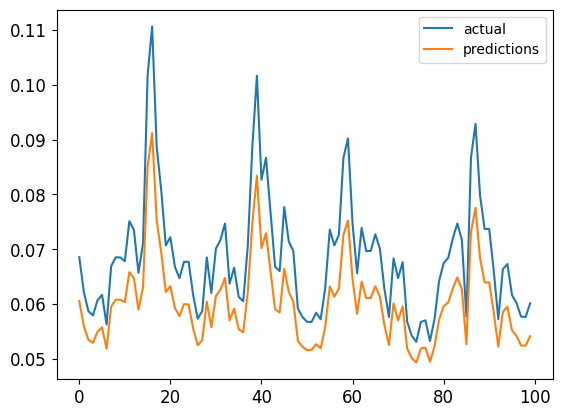

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual4 = actual
actual4.to_csv('model_result/ConvIDresult.csv')
actual4['actual'][:100].plot(legend=True)
actual4['predictions'][:100].plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)